In [1]:
from molsim import MolecularDynamics
import numpy as np
import matplotlib.pyplot as plt
import time

Currently, the code for the MD package is still quite suboptimal! We can easily add some implementations that will speed up the runs. When optimizing code it is best to optimize the parts that are executed most often. In our case, the energy and force calculation is carried out $N^2$ times, meaning it is quite performance heavy. There are a few things that cost performance and by implementing them we can reach about 10x more efficiency.

You can find the force computation in:
`src/molecularDynamics/md.cpp`
in function:
`MolecularDynamics::calculateForce`

##### Lower triangular force computation
The double loop i, j over the numbers of particles both loop over N, while we only need to calculate the lower triangular part of the matrix. Another reason why this is inefficient is because we need an if statement checking i!=j in the inner loop. If statements make code unpredictable for the computer, leading to reduced optimization. 

We can change the loop from i (0, ... N) and j (0, ... N) by only considering pairs where j is larger than i. The easiest option is replacing (i != j) with (i < j), but this does not remove the if statement. Another way would be to loop i from (0, ... N - 1) and j from (i+1, ... N). However, we should consider that the a *force* added to i, should cause a counter force added to j. 

##### Removing pow
Raising powers is expensive for computers! While very architecture dependent here is an overview of clock ticks per operation on floating points:
- Addition / subtraction: 3 cycles
- Multiplication: 3 cycles
- Division: 10-20 cycles
- Square root: 10-20 cycles
- pow, exp, sin, cos, log: 20-100+ cycles

This is why it can be beneficial to prevent the amount of uses of the pow function. In this case we can easily get rid of the std::sqrt function, by working with $r^2$. Furthermore, we can get rid std::pow(r, -12) function by computing $r^{-2}$ and then $r^{-6}$. Precomputing $r^{-6}$ costs one division and 3 multiplications.

#### Adding cutOff radius.
We can safely ignore the energy computation between particles that are far away, as the energy goes to 0 with $r^{-6}$. We can add in a cutoff radius and ignore all particles further away than this radius. While this does introduce an if statement, it **might** improve our efficiency, especially when the box size far exceeds the cutoff radius.

#### Benchmarking
Don't forget to rebuild with `pip install .` in the main directory and restarting the notebook kernel. You can use jupyters timing function `%%timeit` to benchmark your implementations. This function will run the code 7 times and report the average time it took to complete. 

In [2]:
def benchmark(numberOfParticles: list, numberOfCycles: list):
    timings = []
    settings = []
    for nPart in numberOfParticles:
        for nCycle in numberOfCycles:
            start = time.time()
            md = MolecularDynamics(
                numberOfParticles=nPart,
                temperature=1.0, 
                dt=0.005, 
                boxSize=8.0, 
                logLevel=0,
                seed=12,
                useNoseHoover=False,
                sampleFrequency=100
            )
            md.run(int(0.2 * nCycle), equilibrate=True, outputPDB=False)
            md.run(int(0.8 * nCycle), equilibrate=False, outputPDB=True)
            end = time.time()
            
            timings.append(end - start)
            settings.append([nPart, nCycle])
    return np.array(timings).reshape(len(numberOfParticles), len(numberOfCycles)), np.array(settings).reshape(len(numberOfParticles), len(numberOfCycles), 2)

In [ ]:
timings, settings = benchmark(np.logspace(2, 3.5, 4, dtype=np.int32), np.logspace(3, 4.5, 4, dtype=np.int32))

[INFO]:  Class MD created.
[DEBUG]:  Molecular Dynamics program
----------------------------
Number of particles  : 100
Temperature          : 1.000000
delta t              : 0.005000
Box length           : 8.000000
Density              : 0.195312
CutOff radius        : 3.000000
CutOff energy        : -0.005479
Steps run            : 0
Equilibration        : false
Observed temperature : 0.000000
Pressure             : 0.000000
Potential energy     : 0.000000
Kinetic energy       : 0.000000
Conserved energy     : 0.000000
Drift energy         : nan


[DEBUG]:  (Init) initialized momenta.
[DEBUG]:  (Init) Zeroed momentum.
[INFO]:  numGrids 6 gridSize 1.000000
[DEBUG]:  (Init) initial energy: -203.883417
[DEBUG]:  (Init) accepted gradient descent at step 0 energy difference = -41.289179
[DEBUG]:  (Init) rejected gradient descent at step 1 energy difference = 148.322295
[DEBUG]:  (Init) accepted gradient descent at step 2 energy difference = -30.575188
[DEBUG]:  (Init) accepted gradient de

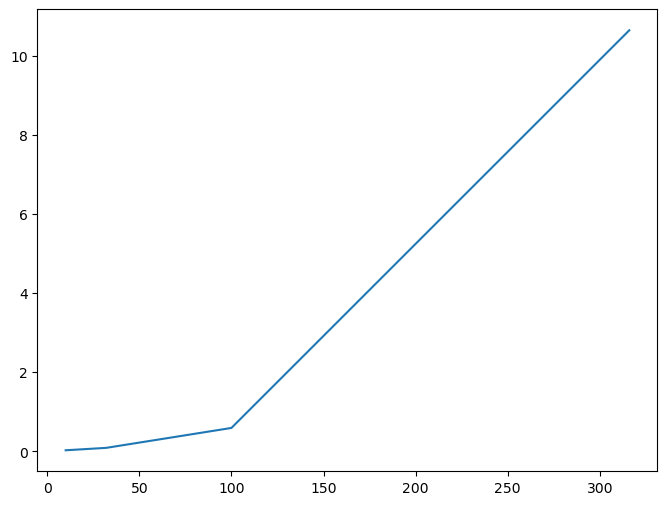

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(settings[:, -1, 0], timings[:, -1])

In [ ]:
settings[:, 0]

array([[  10, 1000],
       [  32, 1000],
       [ 100, 1000],
       [ 316, 1000]])

In [ ]:
settings[:, 0]

array([[  10, 1000],
       [  32, 1000],
       [ 100, 1000],
       [ 316, 1000]])